In [43]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import tensorflow as tf
from google.colab import drive
drive.mount("/content/drive")
tf.config.list_physical_devices('GPU')

dataset = read_csv("/content/drive/MyDrive/Datasets/Dataset.csv")
dataset.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,RID,VISCODE2,ADNI_MEM,ADNI_EF,AGE,GENDER,EDUCATION,MMSCORE,ADDIAGNOSIS
0,2,0,0.486,0.091,74,1,16,28,0
1,2,6,0.581,0.088,75,1,16,28,0
2,2,36,0.405,0.088,77,1,16,29,0
3,2,60,0.352,-0.294,79,1,16,28,0
4,2,72,0.350,0.343,80,1,16,23,1


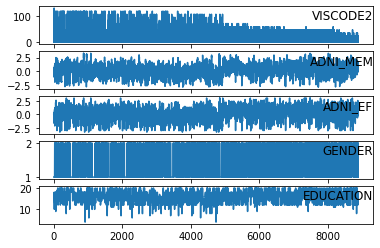

In [44]:
values = dataset.values
# specify columns to plot
groups = [1, 2, 3, 5, 6]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [45]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv("/content/drive/MyDrive/Datasets/Dataset.csv", header = 0,index_col = 0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8,9,10]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var6(t)   var7(t)   var8(t)
1   0.000000   0.543600   0.539499  ...     0.75  0.935484  0.000000
2   0.045455   0.558857   0.539023  ...     0.75  0.967742  0.000000
3   0.272727   0.530593   0.539023  ...     0.75  0.935484  0.000000
4   0.454545   0.522081   0.478426  ...     0.75  0.774194  0.333333
5   0.545455   0.521760   0.579473  ...     0.75  0.806452  0.333333

[5 rows x 11 columns]


In [46]:
# split into train and test sets
values = reframed.values
n_train_days = 300
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(300, 1, 10) (300,) (8596, 1, 10) (8596,)


Epoch 1/8
5/5 - 3s - loss: 0.1845 - accuracy: 0.7833 - val_loss: 0.1771 - val_accuracy: 0.7869 - 3s/epoch - 519ms/step
Epoch 2/8
5/5 - 0s - loss: 0.1670 - accuracy: 0.7833 - val_loss: 0.1606 - val_accuracy: 0.7869 - 167ms/epoch - 33ms/step
Epoch 3/8
5/5 - 0s - loss: 0.1506 - accuracy: 0.7833 - val_loss: 0.1480 - val_accuracy: 0.7869 - 155ms/epoch - 31ms/step
Epoch 4/8
5/5 - 0s - loss: 0.1388 - accuracy: 0.7833 - val_loss: 0.1423 - val_accuracy: 0.7869 - 168ms/epoch - 34ms/step
Epoch 5/8
5/5 - 0s - loss: 0.1353 - accuracy: 0.7833 - val_loss: 0.1407 - val_accuracy: 0.7869 - 159ms/epoch - 32ms/step
Epoch 6/8
5/5 - 0s - loss: 0.1352 - accuracy: 0.7833 - val_loss: 0.1389 - val_accuracy: 0.7869 - 166ms/epoch - 33ms/step
Epoch 7/8
5/5 - 0s - loss: 0.1330 - accuracy: 0.7833 - val_loss: 0.1363 - val_accuracy: 0.7869 - 178ms/epoch - 36ms/step
Epoch 8/8
5/5 - 0s - loss: 0.1300 - accuracy: 0.7833 - val_loss: 0.1341 - val_accuracy: 0.7869 - 169ms/epoch - 34ms/step


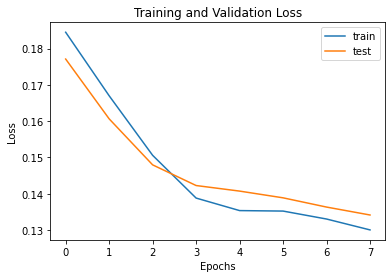

In [47]:
# design network
model = Sequential()
model.add(LSTM(8, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=8, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('Training and Validation Loss')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend()
pyplot.show()

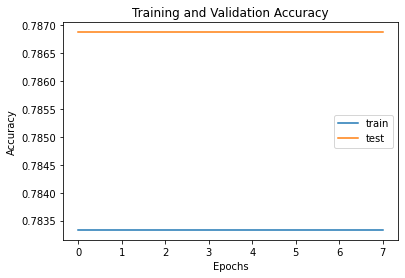

In [48]:
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.title('Training and Validation Accuracy')
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')
pyplot.legend()
pyplot.show()

In [49]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: ignored

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,11)
pyplot.plot(epochs, loss_train, 'g', label='Training accuracy')
pyplot.plot(epochs, loss_val, 'b', label='validation accuracy')
pyplot.title('Training and Validation accuracy')
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')
pyplot.legend()
pyplot.show()